In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
housingDataImputed = pd.read_csv('./imputeImpl_housingData.csv',index_col = 0, na_filter = False)

In [2]:
def check_empty_vals():
    cols=housingDataImputed.columns
    for col in cols:
        null_count=pd.isnull(housingDataImputed[col]).sum()
        if null_count>0:
            print(col,null_count)
        
        
check_empty_vals()

In [127]:
#Imputation analysis notes
# LotFrontage 462 - mean of neighborhood -  Linear feet of street connected to property (Doug)
# Alley 2412 Type of alley access to property Grvl	Grave Pave	Paved NA 	No alley access - REMOVE?
# MasVnrType 14 - impute None Masonry veneer type  
       # BrkCmn	Brick Common BrkFace	Brick Face CBlock	Cinder Block None	NoneStone	Stone
# MasVnrArea 14 - impute 0
# BASEMENT 68 have no values; 1 has NA for BsmtFinSF1, BsmtFinSF2, BsmtUnfSF,TotalBsmtSF
# BASEMENT 2 rows have basement data 814 and 1202
#   BasmtExposure value is missing - impute with mode
#   BsmtFinSF1 and BsmtFinSF2 should be imputed with mean percentage for Unf BsmtFinType2 and BsmtFinType1
# BsmtQual 69 - Evaluates the height of the basement - impute DNE
       #Ex	Excellent (100+ inches)	
       #Gd	Good (90-99 inches)
       #TA	Typical (80-89 inches)
       #Fa	Fair (70-79 inches)
       #Po	Poor (<70 inches
       #NA	No Basement
# BsmtCond 69 - Evaluates the general condition of the basement - impute DNE
       #Ex	Excellent
       #Gd	Good
       #TA	Typical - slight dampness allowed
       #Fa	Fair - dampness or some cracking or settling
       #Po	Poor - Severe cracking, settling, or wetness
       # NA	No Basement
# BsmtExposure 71 -  Refers to walkout or garden level walls - 814 and 1202 impute Mode
       #Gd	Good Exposure
       #Av	Average Exposure (split levels or foyers typically score average or above)	
       #Mn	Mimimum Exposure
       #No	No Exposure
       #NA	No Basement
# BsmtFinType1 69 - Rating of basement finished area - impute DNE
       #GLQ	Good Living Quarters
       #ALQ	Average Living Quarters
       #BLQ	Below Average Living Quarters	
       #Rec	Average Rec Room
       #LwQ	Low Quality
       #Unf	Unfinshed
       #NA	No Basement
# BsmtFinSF1 1 - 913 Type 1 finished square feet - impute 0
# BsmtFinType2 70  Rating of basement finished area (if multiple types) should be DNE
       #GLQ	Good Living Quarters
       #ALQ	Average Living Quarters
       #BLQ	Below Average Living Quarters	
       #Rec	Average Rec Room
       #LwQ	Low Quality
       #Unf	Unfinshed
       #NA	No Basement
# BsmtFinSF2 1  - Rating of basement finished area (if multiple types) - impute 0
       #GLQ	Good Living Quarters
       #ALQ	Average Living Quarters
       #BLQ	Below Average Living Quarters	
       #Rec	Average Rec Room
       #LwQ	Low Quality
       #Unf	Unfinshed
       #NA	No Basement
# BsmtUnfSF 1 913 - Unfinished square feet of basement area - impute 0
# TotalBsmtSF 1 913- Total square feet of basement area - impute 0
# Electrical 1 - Electrical system - impute mode
       #SBrkr	Standard Circuit Breakers & Romex
       #FuseA	Fuse Box over 60 AMP and all Romex wiring (Average)	
       #FuseF	60 AMP Fuse Box and mostly Romex wiring (Fair)
       #FuseP	60 AMP Fuse Box and mostly knob & tube wiring (poor)
       #Mix	Mixed
# BsmtFullBath 2 Basement full bathrooms 913/2309  should be 0
# BsmtHalfBath 2 Basement half bathrooms 913/2309 should be 0 
# FireplaceQu 1241 Fireplace quality (may be thrown out)
       #Ex	Excellent - Exceptional Masonry Fireplace
       #Gd	Good - Masonry Fireplace in main level
       #TA	Average - Prefabricated Fireplace in main living area or Masonry Fireplace in basement
       #Fa	Fair - Prefabricated Fireplace in basement
       #Po	Poor - Ben Franklin Stove
       #NA	No Fireplace
# GarageType 127  Garage location
       #2Types	More than one type of garage
       #Attchd	Attached to home
       #Basment	Basement Garage
       #BuiltIn	Built-In (Garage part of house - typically has room above garage)
       #CarPort	Car Port
       #Detchd	Detached from home
       #NA	No Garage
# GarageYrBlt 129 - Year garage was built
# GarageFinish 129 Interior finish of the garage - not well correlated
       #Fin	Finished
       #RFn	Rough Finished	
       #Unf	Unfinished
       #NA	No Garage
# GarageCars 1 - Size of garage in car capacity correlated
# GarageArea 1 - Size of garage in square feet correlated
# GarageQual 129 - Garage quality
       #Ex	Excellent
       #Gd	Good
       #TA	Typical/Average
       #Fa	Fair
       #Po	Poor
       #NA	No Garage
# GarageCond 129 - Garage condition
       #Ex	Excellent
       #Gd	Good
       #TA	Typical/Average
       #Fa	Fair
       #Po	Poor
       #NA	No Garage
# PoolQC 2571 -  Pool quality - throw out
       #Ex	Excellent
       #Gd	Good
       #TA	Average/Typical
       #Fa	Fair
       #NA	No Pool
# Fence 2055 - Fence quality - throw out
       #GdPrv	Good Privacy
       #MnPrv	Minimum Privacy
       #GdWo	Good Wood
       #MnWw	Minimum Wood/Wire
       #NA	No Fence
# MiscFeature 2483 Miscellaneous feature not covered in other categories - throw out - not enough data points
       #Elev	Elevator
       #Gar2	2nd Garage (if not described in garage section)
       #Othr	Other
       #Shed	Shed (over 100 SF)
       #TenC	Tennis Court
       #NA	None

In [43]:
numeric_features=list(housingDataImputed.select_dtypes(include=[np.number]).columns.values)
cat_features=list(housingDataImputed.select_dtypes(exclude=[np.number]).columns.values)
housingDataImputed[numeric_features].corr().to_csv('x_numeric_corr.csv')
numeric_features.remove('SalePrice')
numeric_features.remove('PID')
cat_features

['MSZoning',
 'Street',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'PoolQC',
 'Fence',
 'SaleType',
 'SaleCondition']

In [7]:
housingDataImputed[numeric_features].head()

,GrLivArea,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscFeature,MiscVal,MoSold,YrSold
0,856,30,58.77,7890,6,6,1939,1950,0.0,238.0,...,0,0,0,0,166,0,0,0,3,2010
1,1049,120,42.00,4235,5,5,1984,1984,149.0,552.0,...,0,105,0,0,0,0,0,0,2,2009
3,1039,70,80.00,8146,4,8,1900,2003,0.0,0.0,...,0,0,168,0,111,0,0,0,5,2009
4,1665,60,70.00,8400,8,6,2001,2001,0.0,643.0,...,0,45,0,0,0,0,0,0,11,2009
5,1922,85,64.00,7301,7,5,2003,2003,500.0,0.0,...,0,0,177,0,0,0,0,0,7,2009


array([[<AxesSubplot:title={'center':'GrLivArea'}>,
        <AxesSubplot:title={'center':'MSSubClass'}>,
        <AxesSubplot:title={'center':'LotFrontage'}>,
        <AxesSubplot:title={'center':'LotArea'}>,
        <AxesSubplot:title={'center':'OverallQual'}>,
        <AxesSubplot:title={'center':'OverallCond'}>],
       [<AxesSubplot:title={'center':'YearBuilt'}>,
        <AxesSubplot:title={'center':'YearRemodAdd'}>,
        <AxesSubplot:title={'center':'MasVnrArea'}>,
        <AxesSubplot:title={'center':'BsmtFinSF1'}>,
        <AxesSubplot:title={'center':'BsmtFinSF2'}>,
        <AxesSubplot:title={'center':'BsmtUnfSF'}>],
       [<AxesSubplot:title={'center':'TotalBsmtSF'}>,
        <AxesSubplot:title={'center':'1stFlrSF'}>,
        <AxesSubplot:title={'center':'2ndFlrSF'}>,
        <AxesSubplot:title={'center':'LowQualFinSF'}>,
        <AxesSubplot:title={'center':'BsmtFullBath'}>,
        <AxesSubplot:title={'center':'BsmtHalfBath'}>],
       [<AxesSubplot:title={'center':'Ful

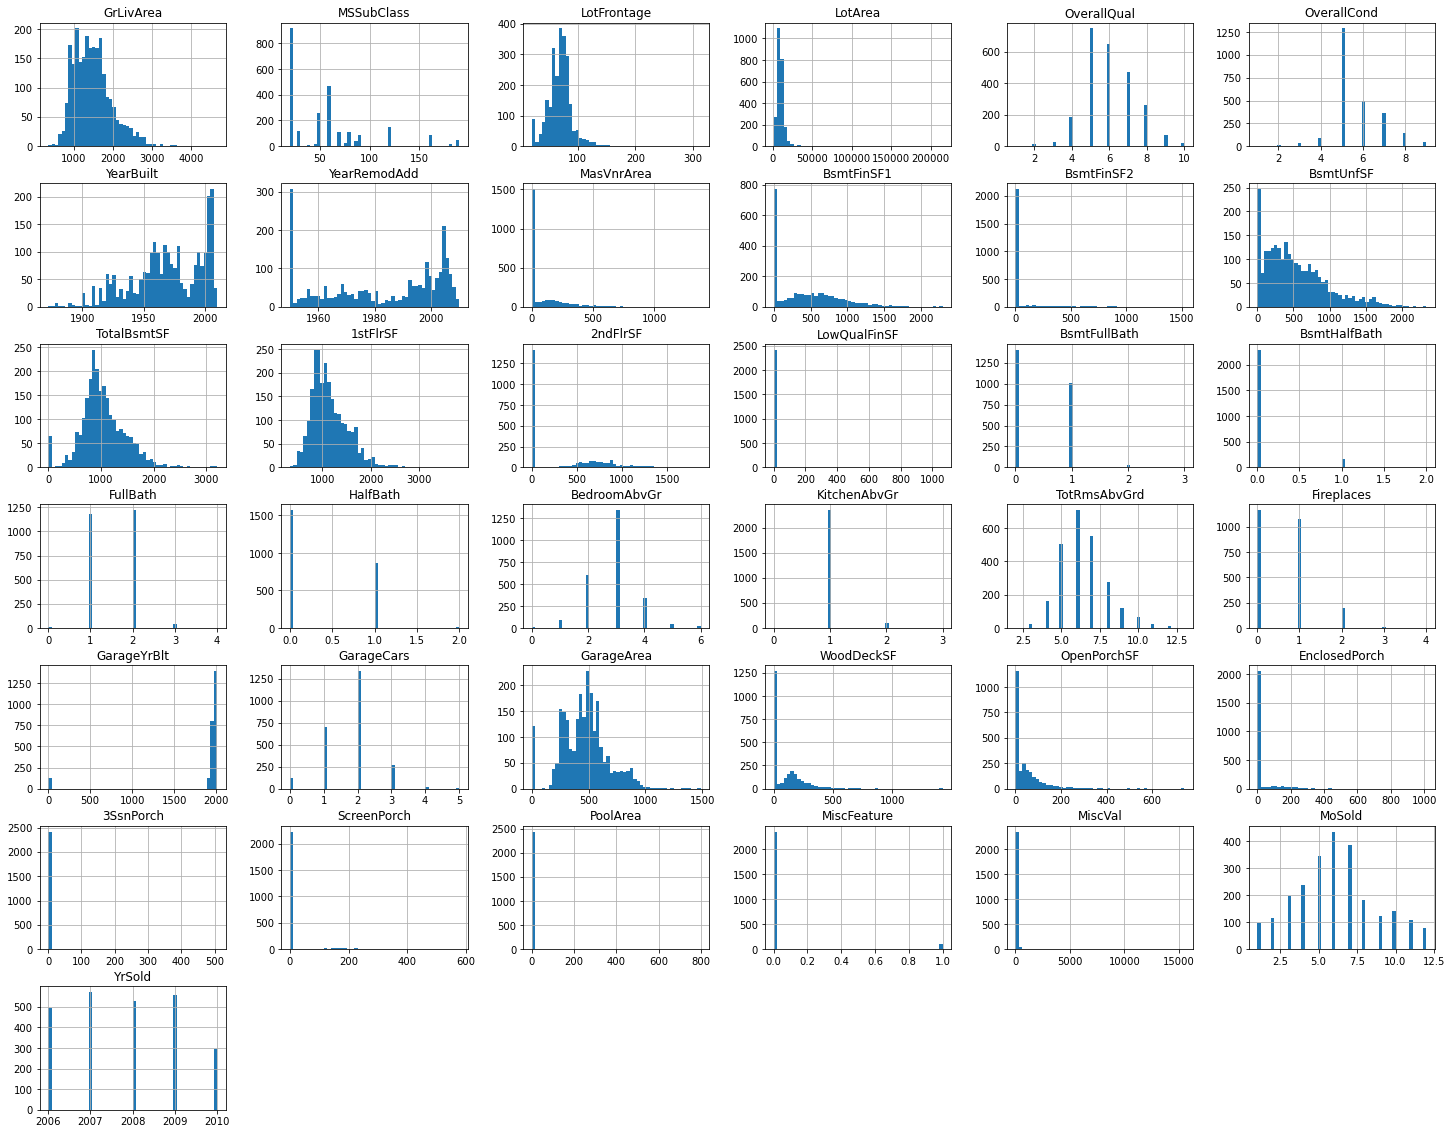

In [8]:
housingDataImputed[numeric_features].hist(bins=50,figsize=(25,20))

In [11]:
housingDataImputed[numeric_features].corr().to_csv('x_numeric_corr.csv')

In [53]:

X_vars = numeric_features 
Y_var = ['SalePrice']

X=housingDataImputed[X_vars]
y=housingDataImputed[Y_var]
#Calculate Base VIF of numerical features
from statsmodels.stats.outliers_influence import variance_inflation_factor 
vif_data = pd.DataFrame()
vif_data["Column"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))] 
print(vif_data.sort_values('VIF'))

#Remove possible multicolinear numerical variables
X_vars2=numeric_features.copy()
X_vars2.remove("2ndFlrSF")
X_vars2.remove("BsmtUnfSF")
X_vars2.remove("BsmtFinSF2")
X_vars2.remove("BsmtFinSF1")

print(X_vars2)
X2=housingDataImputed[X_vars2]
vif2_data = pd.DataFrame()
vif2_data["Column"] = X2.columns
vif2_data["VIF"] = [variance_inflation_factor(X2.values, i) for i in range(len(X2.columns))] 
print(vif2_data.sort_values('VIF'))

X_vars3=["3SsnPorch","PoolArea","LowQualFinSF","BsmtHalfBath","ScreenPorch","MiscVal","EnclosedPorch","MiscFeature","OpenPorchSF","MasVnrArea","WoodDeckSF","BsmtFullBath","Fireplaces","LotArea","HalfBath","MSSubClass","OverallQual"]

X3=housingDataImputed[X_vars3]
vif3_data = pd.DataFrame()
vif3_data["Column"] = X3.columns
vif3_data["VIF"] = [variance_inflation_factor(X3.values, i) for i in range(len(X3.columns))] 
print(vif3_data.sort_values('VIF'))


/Users/chitrasharathchandra/opt/anaconda3/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


           Column           VIF
30      3SsnPorch  1.030389e+00
32       PoolArea  1.056711e+00
31    ScreenPorch  1.179741e+00
17   BsmtHalfBath  1.259549e+00
34        MiscVal  1.355821e+00
29  EnclosedPorch  1.371793e+00
33    MiscFeature  1.428078e+00
28    OpenPorchSF  1.760283e+00
27     WoodDeckSF  1.921565e+00
8      MasVnrArea  1.924647e+00
23     Fireplaces  2.940482e+00
3         LotArea  3.276608e+00
19       HalfBath  3.314418e+00
16   BsmtFullBath  3.630716e+00
1      MSSubClass  4.522356e+00
35         MoSold  6.437919e+00
2     LotFrontage  1.993323e+01
18       FullBath  2.425349e+01
20   BedroomAbvGr  3.144914e+01
26     GarageArea  3.352452e+01
24    GarageYrBlt  3.395861e+01
25     GarageCars  4.079770e+01
5     OverallCond  4.122356e+01
21   KitchenAbvGr  4.271617e+01
4     OverallQual  6.194102e+01
22   TotRmsAbvGrd  8.443281e+01
6       YearBuilt  1.578726e+04
7    YearRemodAdd  1.989838e+04
36         YrSold  2.149911e+04
14       2ndFlrSF           inf
13      

In [55]:
desirable_neighborhoods=["StoneBr","NridgHt","NoRidge"]   
housingDataImputed['DesirableNeighborhood']=housingDataImputed.Neighborhood.map(lambda t:1 if t in desirable_neighborhoods else 0)
housingDataImputed['BuiltInGarage']=housingDataImputed.GarageType.map(lambda t:1 if t in ['Attchd','BuiltIn'] else 0)
housingDataImputed['central_air']=housingDataImputed.GarageType.map(lambda t:1 if t=="Yes" else 0)
housingDataImputed['GoodKitchen']=housingDataImputed.GarageType.map(lambda t:1 if t in ['Excellent','Good'] else 0)
housingDataImputed['WalkoutBasement']=housingDataImputed.BsmtExposure.map(lambda t:1 if t in ['Good Exposure','Average Exposure'] else 0)
housingDataImputed['BasementQuality']=housingDataImputed.BsmtQual.map(lambda t:1 if t in ['Ex','Gd'] else 0)
housingDataImputed['StreetType']=housingDataImputed.Street.map(lambda t:1 if t=="Pave" else 0)
housingDataImputed['LandContourHLS']=housingDataImputed.LandContour.map(lambda t:1 if t=="HLS" else 0)
housingDataImputed['PubUtilities']=housingDataImputed.Utilities.map(lambda t:1 if t=="AllPub" else 0)
housingDataImputed['GreatLocation1']=housingDataImputed.Condition1.map(lambda t:1 if t in ['PosN','PosA'] else 0)
housingDataImputed['GreatLocation2']=housingDataImputed.Condition2.map(lambda t:1 if t in ['PosN','PosA'] else 0)
housingDataImputed['GoodRoofMat']=housingDataImputed.RoofMatl.map(lambda t:1 if t in ['WdShngl','Membran'] else 0)
housingDataImputed['GoodExterior1']=housingDataImputed.Exterior1st.map(lambda t:1 if t in ['ImStucc','PreCast'] else 0)
housingDataImputed['GoodExterior2']=housingDataImputed.Exterior2nd.map(lambda t:1 if t in ['ImStucc','PreCast'] else 0)
housingDataImputed['GoodExteriorQual']=housingDataImputed.ExterQual.map(lambda t:1 if t=="Ex" else 0)
housingDataImputed['LivableBasement1']=housingDataImputed.BsmtFinType1.map(lambda t:1 if t=="GLQ" else 0)
housingDataImputed['LivableBasement2']=housingDataImputed.BsmtFinType2.map(lambda t:1 if t=="GLQ" else 0)
housingDataImputed['GasHeating']=housingDataImputed.Heating.map(lambda t:1 if t in ['GasA','GasW'] else 0)
housingDataImputed['HeatingQuality']=housingDataImputed.HeatingQC.map(lambda t:1 if t in ['Ex','Gd'] else 0)
housingDataImputed['AirConditioning']=housingDataImputed.CentralAir.map(lambda t:1 if t=="Y" else 0)
housingDataImputed['FunctionDeduction']=housingDataImputed.Functional.map(lambda t:1 if t=="Typ" else 0)
housingDataImputed['FireplaceQuality']=housingDataImputed.FireplaceQu.map(lambda t:1 if t in ['Ex','Gd'] else 0)
housingDataImputed['GarageFinished']=housingDataImputed.GarageFinish.map(lambda t:1 if t=="Fin" else 0)
housingDataImputed['GoodGarage']=housingDataImputed.GarageQual.map(lambda t:1 if t in ["Ex","Gd"] else 0)
housingDataImputed['GoodPool']=housingDataImputed.PoolQC.map(lambda t:1 if t in ["Ex","Gd"] else 0)
housingDataImputed['NewHome']=housingDataImputed.GarageQual.map(lambda t:1 if t=="New" else 0)
features_engineered=['DesirableNeighborhood','BuiltInGarage','central_air','GoodKitchen','WalkoutBasement', 'BasementQuality',
                    'StreetType','LandContourHLS','PubUtilities','GreatLocation1','GreatLocation2','GoodRoofMat',
                    'GoodExterior1','GoodExterior2','GoodExteriorQual','LivableBasement1','LivableBasement2',
                    'GasHeating','HeatingQuality','AirConditioning','FunctionDeduction','FireplaceQuality',
                    'GarageFinished','GoodGarage','GoodPool','NewHome']

In [59]:
X_vars = numeric_features +features_engineered
Y_var = ['SalePrice']

X=housingDataImputed[X_vars]
y=housingDataImputed[Y_var]
#Calculate Base VIF of numerical features
from statsmodels.stats.outliers_influence import variance_inflation_factor 
vif_data = pd.DataFrame()
vif_data["Column"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))] 
print(vif_data.sort_values('VIF')[0:40])

/Users/chitrasharathchandra/opt/anaconda3/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


                   Column        VIF
30              3SsnPorch   1.040786
60             GoodGarage   1.081839
48            GoodRoofMat   1.099831
44         LandContourHLS   1.124944
46         GreatLocation1   1.156130
49          GoodExterior1   1.189801
31            ScreenPorch   1.203285
50          GoodExterior2   1.209051
47         GreatLocation2   1.215895
17           BsmtHalfBath   1.280341
53       LivableBasement2   1.331761
34                MiscVal   1.360380
29          EnclosedPorch   1.397575
33            MiscFeature   1.467717
51       GoodExteriorQual   1.493594
61               GoodPool   1.553225
32               PoolArea   1.559651
59         GarageFinished   1.781177
28            OpenPorchSF   1.798295
37  DesirableNeighborhood   1.889585
27             WoodDeckSF   1.961217
8              MasVnrArea   2.109190
58       FireplaceQuality   2.131994
52       LivableBasement1   2.970041
19               HalfBath   3.415002
3                 LotArea   3.493711
2

/Users/chitrasharathchandra/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss
